- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np

In [7]:
#Get data 
# Read in the data
dataset = "partial_database.csv"
df = pd.read_csv(dataset)


"""
# Decomment this part if you dont have the labels in the csv file
# Read class labels
f = open("labelsDefault.txt", "r")
labels=f.read().splitlines()
labels.pop(0)

# Add y column, which is the target variable
df['y'] = list(map(int,labels))
"""
# Get X and y
Y=df['y']
X=df.drop(['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
numbers_of_classes=np.unique(Y)

In [14]:
#Optimization 
model=MultinomialNB()
param_grid = {'alpha': np.linspace(0.5, 1.5, 6),
              'fit_prior': [True, False]}

random=RandomizedSearchCV(model,param_grid,cv=5,scoring='accuracy',n_jobs=-1)
random.fit(X,Y)
print(random.best_params_)

{'fit_prior': True, 'alpha': 0.9}


Accuracy for class 1,2,3,4,5,6,7: 0.8136645962732919
accuracy global 0.2776679841897233
Accuracy for class 8,9,10: 0.8188405797101449
accuracy global 0.3794466403162055
Accuracy for class 11,12,13: 0.6811594202898551
accuracy global 0.42193675889328064
Accuracy for class 14,15,16: 0.572463768115942
accuracy global 0.4762845849802372
Accuracy for class 17,18,19: 0.5942028985507246
accuracy global 0.5434782608695652
Accuracy for class 20,21,22: 0.2826086956521739
accuracy global 0.5563241106719368


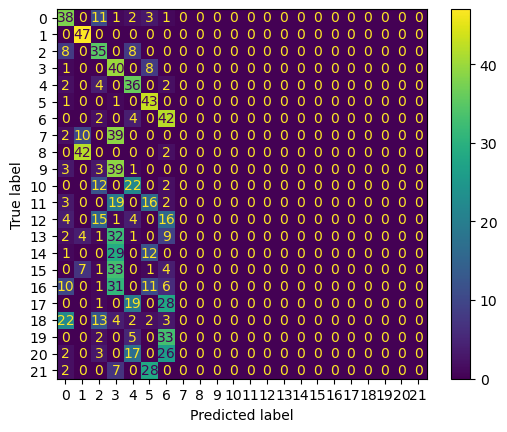

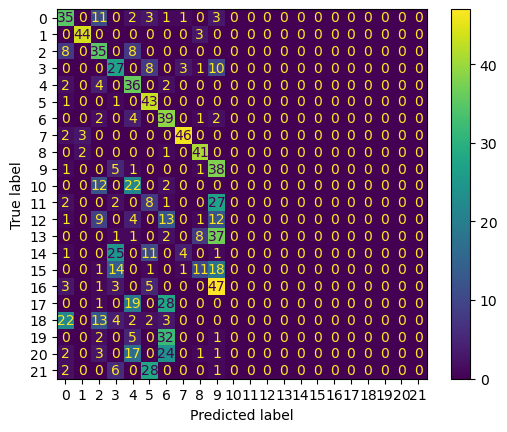

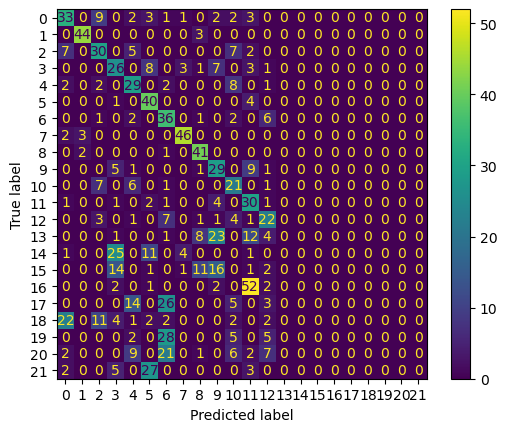

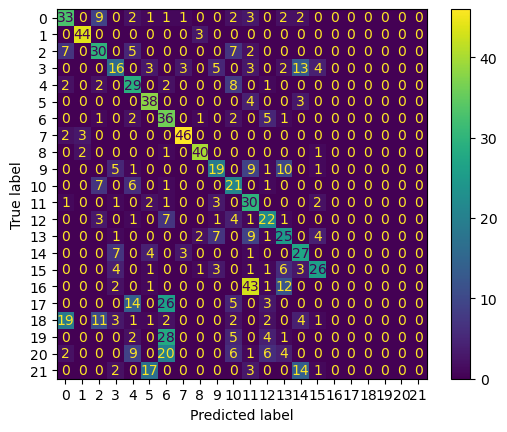

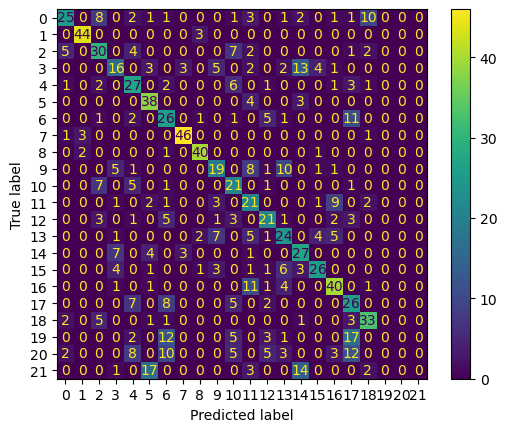

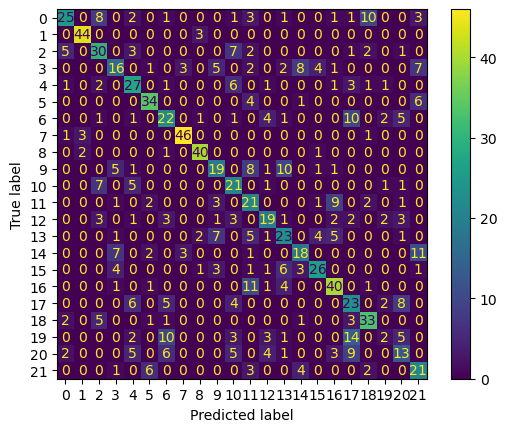

In [17]:
##Split by class, to increment by class:
#Get dataframe of class 1,2,3,4,5,6,7
df1=df.loc[df['y'].isin([1,2,3,4,5,6,7])]
Y1=df1['y']
X1=df1.drop(['y'],axis=1)

#Get dataframe of class 8,9,10
df2=df.loc[df['y'].isin([8,9,10])]
Y2=df2['y']
X2=df2.drop(['y'],axis=1)

#Get dataframe of class 11,12,13
df3=df.loc[df['y'].isin([11,12,13])]
Y3=df3['y']
X3=df3.drop(['y'],axis=1)

#Get dataframe of class 14,15,16
df4=df.loc[df['y'].isin([14,15,16])]
Y4=df4['y']
X4=df4.drop(['y'],axis=1)

#Get dataframe of class 17,18,19
df5=df.loc[df['y'].isin([17,18,19])]
Y5=df5['y']
X5=df5.drop(['y'],axis=1)

#Get dataframe of class 20,21,22
df6=df.loc[df['y'].isin([20,21,22])]
Y6=df6['y']
X6=df6.drop(['y'],axis=1)

#Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.2, random_state=1, shuffle=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=1, shuffle=True)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y3, test_size=0.2, random_state=1, shuffle=True)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, Y4, test_size=0.2, random_state=1, shuffle=True)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, Y5, test_size=0.2, random_state=1, shuffle=True)
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, Y6, test_size=0.2, random_state=1, shuffle=True)

#Train model
model=MultinomialNB(alpha= 0.9,fit_prior=True)
model.partial_fit(X_train1,y_train1,classes=numbers_of_classes)
print("Accuracy for class 1,2,3,4,5,6,7:",model.score(X_test1,y_test1))
print("accuracy global",model.score(X_test,y_test))

y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.partial_fit(X_train2,y_train2,classes=numbers_of_classes)
print("Accuracy for class 8,9,10:",model.score(X_test2,y_test2))
print("accuracy global",model.score(X_test,y_test))

y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.partial_fit(X_train3,y_train3,classes=numbers_of_classes)
print("Accuracy for class 11,12,13:",model.score(X_test3,y_test3))
print("accuracy global",model.score(X_test,y_test))

y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.partial_fit(X_train4,y_train4,classes=numbers_of_classes)
print("Accuracy for class 14,15,16:",model.score(X_test4,y_test4))
print("accuracy global",model.score(X_test,y_test))

y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.partial_fit(X_train5,y_train5,classes=numbers_of_classes)
print("Accuracy for class 17,18,19:",model.score(X_test5,y_test5))
print("accuracy global",model.score(X_test,y_test))

y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.partial_fit(X_train6,y_train6,classes=numbers_of_classes)
print("Accuracy for class 20,21,22:",model.score(X_test6,y_test6))
print("accuracy global",model.score(X_test,y_test))

y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Fold  0
accuracy_score on fold  0.5968379446640316
accuracy_score on all:  0.5482213438735178
Fold  1
accuracy_score on fold  0.6561264822134387
accuracy_score on all:  0.5505928853754941
Fold  2
accuracy_score on fold  0.6185770750988142
accuracy_score on all:  0.5509881422924902
Fold  3
accuracy_score on fold  0.567193675889328
accuracy_score on all:  0.549802371541502
Fold  4
accuracy_score on fold  0.5612648221343873
accuracy_score on all:  0.55
Fold  5
accuracy_score on fold  0.5098814229249012
accuracy_score on all:  0.5515810276679842
Fold  6
accuracy_score on fold  0.5098814229249012
accuracy_score on all:  0.549209486166008
Fold  7
accuracy_score on fold  0.45652173913043476
accuracy_score on all:  0.549209486166008
Fold  8
accuracy_score on fold  0.4644268774703557
accuracy_score on all:  0.549802371541502
Fold  9
accuracy_score on fold  0.5
accuracy_score on all:  0.549802371541502


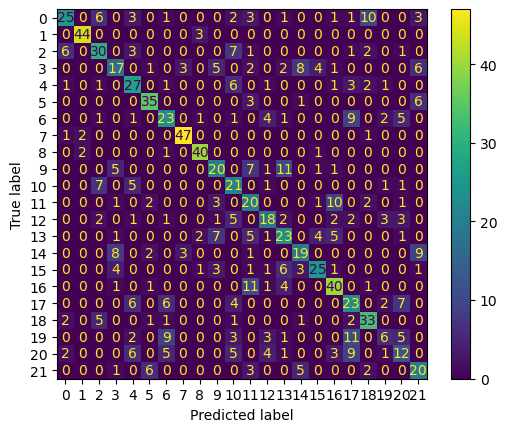

In [18]:
##Split by data, to increment by data:
model=MultinomialNB(alpha= 0.9,fit_prior=True)

number_of_classes = np.linspace(1,22,22)

skf=StratifiedKFold(n_splits=10,shuffle=False)
skf.get_n_splits(X, Y)
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
     print("Fold ",i)
     df_train_fold=df.iloc[train_index]
     X_train_fold=df_train_fold.drop(['y'],axis=1)
     Y_train_fold=df_train_fold['y']

     df_test_fold=df.iloc[test_index]
     X_test_fold=df_test_fold.drop(['y'],axis=1)
     Y_test_fold=df_test_fold['y']

     model.partial_fit(X_train_fold, Y_train_fold, classes=number_of_classes)
     print("accuracy_score on fold ",accuracy_score(Y_test_fold, model.predict(X_test_fold)))
     print("accuracy_score on all: ",accuracy_score(Y, model.predict(X)))

y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()